## Gibbs sampler for a normal model



The data 
$rainfall.dat$ consist of daily records, from the beginning of 1948 to the end of 1983,
 of precipitation (rain or snow in units of  $\frac{1}{100}$ inch, and records of zero precipitation are excluded) at Snoqualmie Falls, Washington. Normal model. Assume the daily precipitation 
 $\left\{ y_{1},...,y_{n}\right\} $ are independent normally distributed, $y_{1},...,y_{n}|\mu,\sigma^{2}\sim\mathcal{N}(\mu,\sigma^{2})$ where both $\mu$ and $\sigma^{2}$ are unknown. Let  $\mu\sim\mathcal{N}(\mu_{0},\tau_{0}^{2})$
 independently of  $\sigma^{2}\sim Inv\text{-}\chi^{2}(\nu_{0},\sigma_{0}^{2})$


- (a) Implement (code!) a Gibbs sampler that simulates from the joint posterior $p(\mu,\sigma^{2}|y_{1},...,y_{n})$ The full conditional posteriors are given on the slides from Lecture 7.Evaluate the convergence of the Gibbs sampler by by calculating the Inefficiency Factors (IFs) and plotting the trajectories of the sampled Markov chains.



- (b)Plot the following densities in one figure: 1) a histogram or kernel density estimate of the daily precipitation $\left\{ y_{1},...,y_{n}\right\} $ The resulting posterior predictive density $p(\tilde y|{y_1}, \ldots ,{y_n})$ using the simulated posterior draws from (a). How well does the posterior predictive density agree with this data?

In [1]:
rainfall = read.table('rainfall.dat')
attach(rainfall)

In [2]:
rain=rainfall$V1

### full condition on $\mu$

 \[\mu \propto {\text{N}}\left( {\mu \mid \frac{{n\bar y/{\sigma ^2} + {\mu _0}/\sigma _0^2}}{{n/{\sigma ^2} + 1/\sigma _0^2}},{\mkern 1mu} \frac{1}{{n/{\sigma ^2} + 1/\sigma _0^2}}} \right)\]

In [3]:
update_mu = function(n, ybar, sig2, mu_0, sig2_0) {
  sig2_1 = 1.0 / (n / sig2 + 1.0 / sig2_0)
  mu_1 = sig2_1 * (n * ybar / sig2 + mu_0 / sig2_0)
  rnorm(n=1, mean=mu_1, sd=sqrt(sig2_1))
}

### The full conditional for $\sigma^2$ given $\mu$ and data is

\[\sigma^2 \propto {\text{IG}}\left( {{\sigma ^2}\mid {\nu _0} + \frac{n}{2},{\mkern 1mu} {\beta _0} + \frac{{\sum\limits_{i = 1}^n {{{({y_i} - \mu )}^2}} }}{2}} \right)\]

In [4]:
update_sig2 = function(n, y, mu, nu_0, beta_0) {
  nu_1 = nu_0 + n / 2.0
  sumsq = sum( (y - mu)^2 ) # vectorized
  beta_1 = beta_0 + sumsq / 2.0
  out_gamma = rgamma(n=1, shape=nu_1, rate=beta_1) # rate for gamma is shape for inv-gamma
  1.0 / out_gamma # reciprocal of a gamma random variable is distributed inv-gamma
}

With functions for drawing from the full conditionals, we are ready to write a function to perform Gibbs sampling.

In [92]:
gibbs = function(y, n_iter, init, prior) {
  ybar = mean(y)
  n = length(y)
  
  ## initialize
  mu_out = numeric(n_iter)
  sig2_out = numeric(n_iter)
  
  mu_now = init$mu
  
  ## Gibbs sampler
  for (i in 1:n_iter) {
    sig2_now = update_sig2(n=n, y=y, mu=mu_now, nu_0=prior$nu_0, beta_0=prior$beta_0)
    mu_now = update_mu(n=n, ybar=ybar, sig2=sig2_now, mu_0=prior$mu_0, sig2_0=prior$sig2_0)
    
    sig2_out[i] = sig2_now
    mu_out[i] = mu_now
  }
  
  cbind(mu=mu_out, sig2=sig2_out)
}

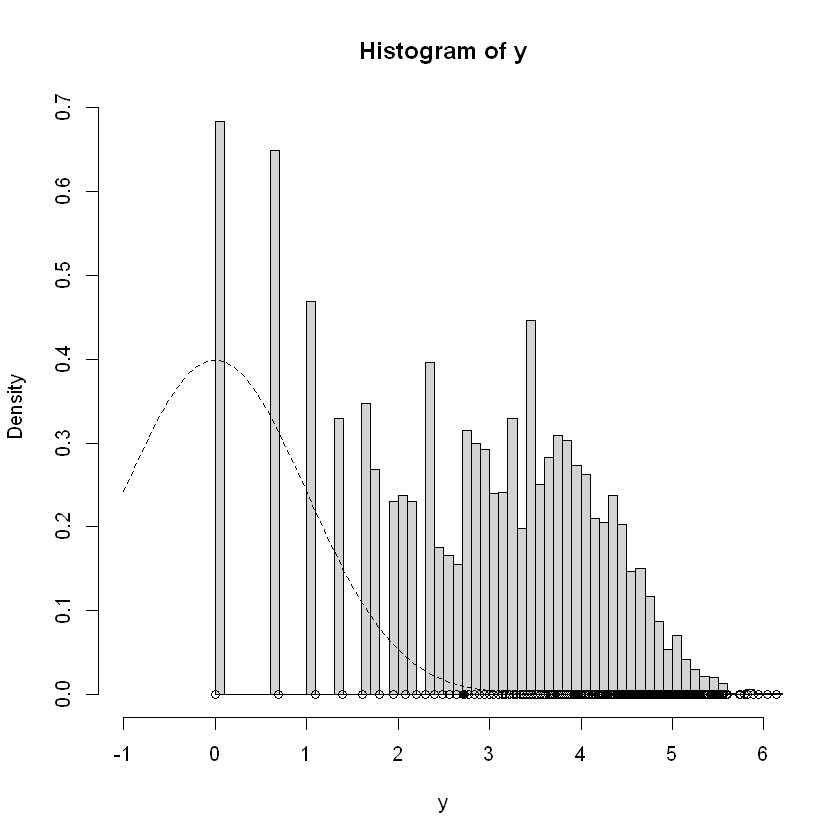

In [93]:
y= log(rain)

ybar = mean(y)
n = length(y)

## prior
prior = list()
prior$mu_0 = 0.0
prior$sig2_0 = 1.0
prior$n_0 = 2.0 # prior effective sample size for sig2
prior$s2_0 = 1.0 # prior point estimate for sig2
prior$nu_0 = prior$n_0 / 2.0 # prior parameter for inverse-gamma
prior$beta_0 = prior$n_0 * prior$s2_0 / 2.0 # prior parameter for inverse-gamma

hist(y, freq=FALSE, xlim=c(-1.0, 6.0),breaks=50) # histogram of the data
curve(dnorm(x=x, mean=prior$mu_0, sd=sqrt(prior$sig2_0)), lty=2, add=TRUE) # prior for mu
points(y, rep(0,n), pch=1) # individual data points
points(ybar, 0, pch=19) # sample mean


Now we are ready to set up the problem in R.



In [94]:
n=length(y)
ybar = mean(y)
## prior

set.seed(123)

init = list()
init$mu = 0.0

post = gibbs(y=y, n_iter=1e3, init=init, prior=prior)

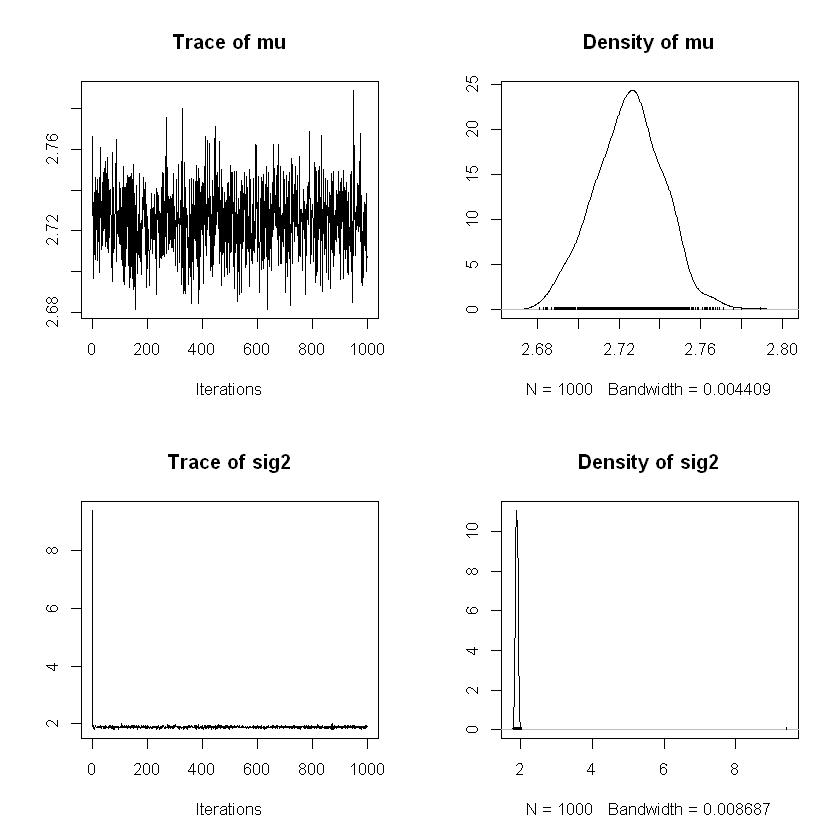

In [95]:
library("coda")
plot(as.mcmc(post))

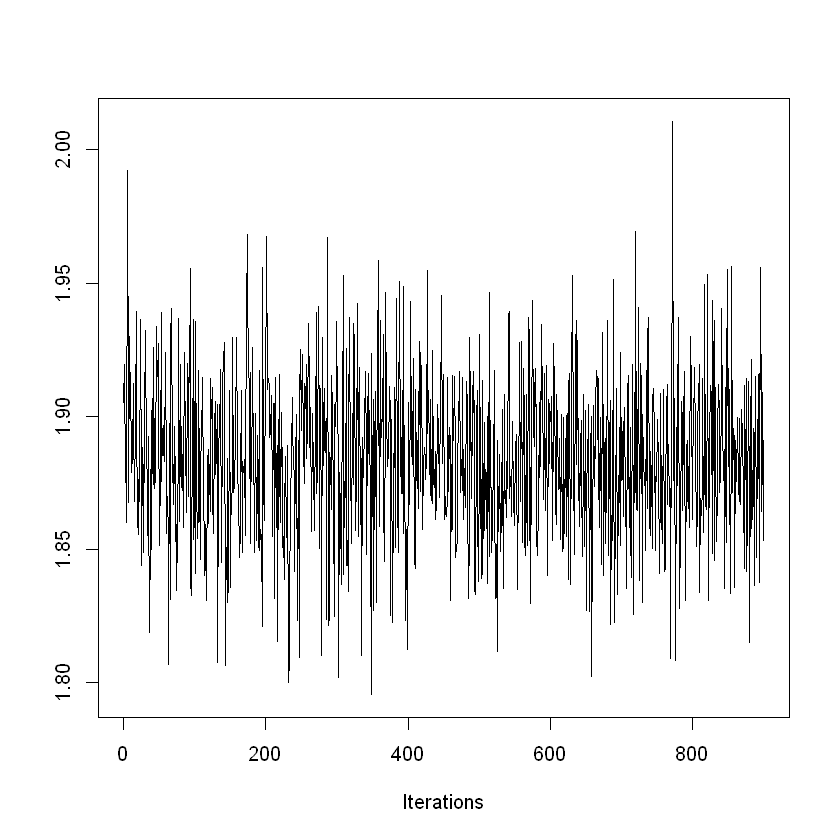

In [96]:
sigma_keep = post[,2]
sigma_keep = sigma_keep[-c(1:100)] #discard the first 100 iteration
traceplot(as.mcmc(sigma_keep))

In [97]:
print('autocorrelation for mu')
autocorr.diag(as.mcmc(post[,1]))


[1] "autocorrelation for mu"


Lag 0,1.000000000
Lag 1,0.054887605
Lag 5,-0.010333817
Lag 10,0.008848957
Lag 50,-0.006364898


In [98]:
print('autocorrelation for sigma')

autocorr.diag(as.mcmc(post[,2]))

[1] "autocorrelation for sigma"


Lag 0,1.000000000
Lag 1,0.006647536
Lag 5,-0.010041007
Lag 10,0.003821135
Lag 50,-0.001157778


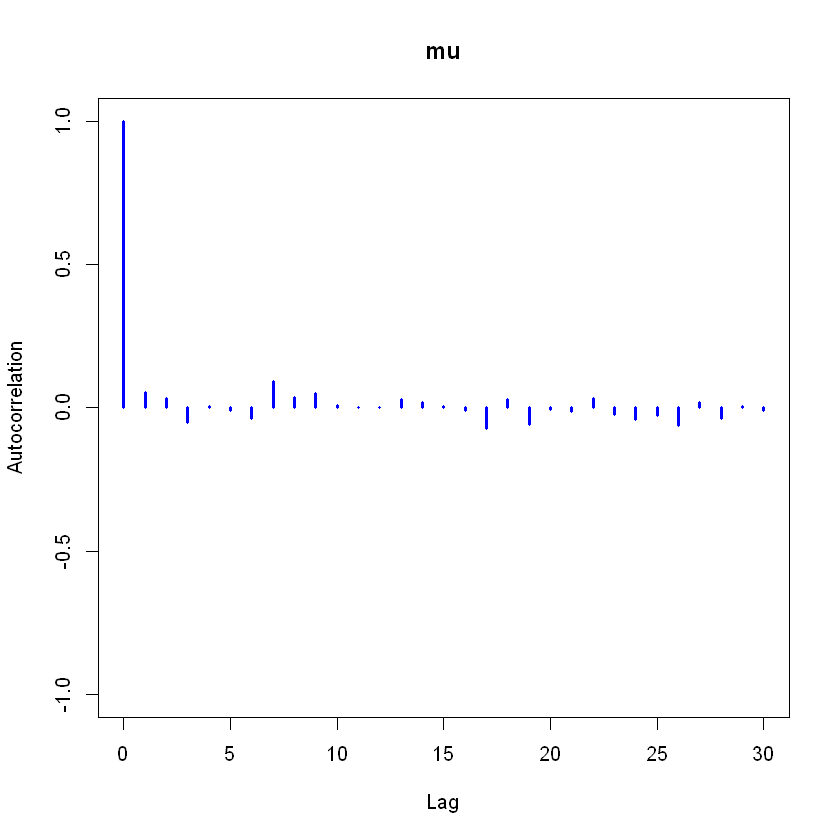

In [99]:
autocorr.plot(as.mcmc(post[,1]),main='mu',lwd=3,col='blue')

autocorrelation tells us how much information is available in Markov chain. we can see that we obtain a larg amount information in each chain

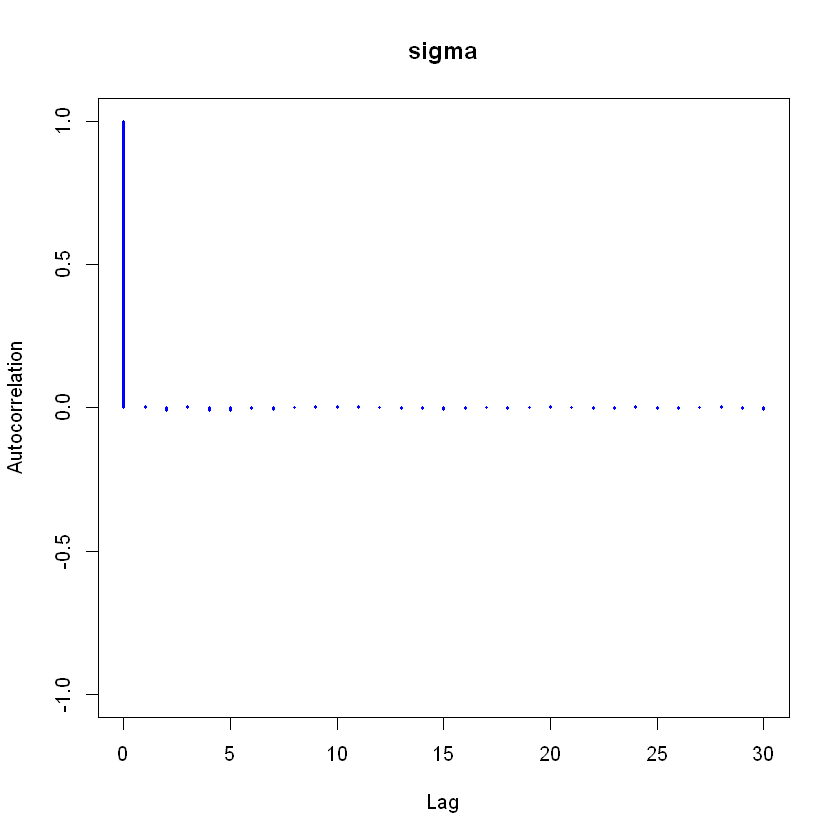

In [100]:
autocorr.plot(as.mcmc(post[,2]),main='sigma',lwd=3,col='blue')

Autocorrelation is a major component in calculating the Monte Carlo effective sample size of your chain. The Monte Carlo effective sample size is how many independent samples from the stationary distribution you would have to draw to have equivalent information in your Markov chain. Essentially it is the m (sample size) we chose in the lesson on Monte Carlo estimation

In [65]:
str(post)

 num [1:10000, 1:2] 2.77 2.73 2.73 2.7 2.73 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "mu" "sig2"


In [66]:
post2 = data.frame(post)

In [68]:
effectiveSize(as.mcmc(post2$mu))

var1 
10344.02

for $1000$ iteration about 823 iteration contains information . which is very good.

In [69]:
effectiveSize(as.mcmc(post2$sig2))

var1 
10000

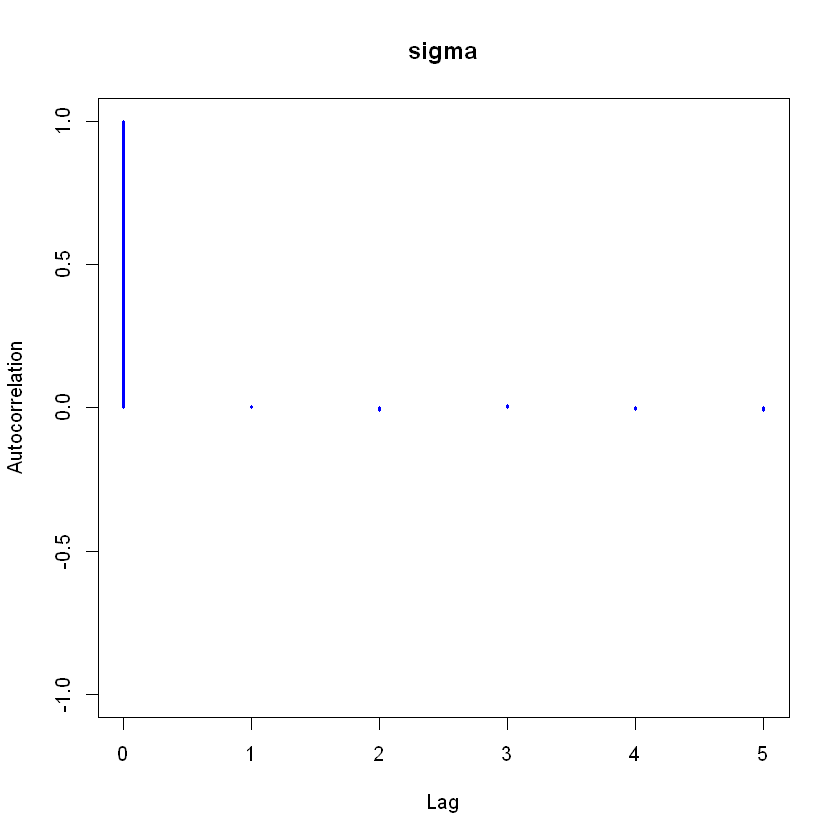

In [70]:
autocorr.plot(as.mcmc(post[,2]),main='sigma',lwd=3,col='blue',lag.max = 5)

In [71]:
raftery.diag(as.mcmc(post[,1]))


Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                       
 Burn-in  Total Lower bound  Dependence
 (M)      (N)   (Nmin)       factor (I)
 2        3710  3746         0.99      


In [101]:
1+2*sum(autocorr.diag(as.mcmc(post[,1])))

[1] 3.094076

In [102]:
1+2*sum(autocorr.diag(as.mcmc(post[,2])))

[1] 2.99854

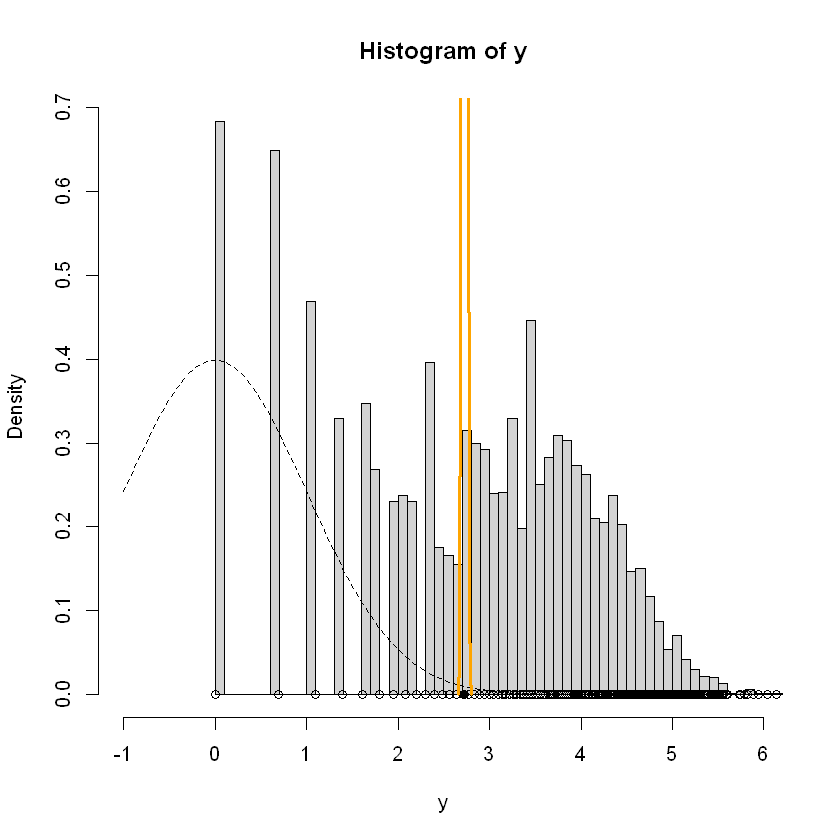

In [103]:
y= log(rain)

ybar = mean(y)
n = length(y)

## prior
prior = list()
prior$mu_0 = 0.0
prior$sig2_0 = 1.0
prior$n_0 = 2.0 # prior effective sample size for sig2
prior$s2_0 = 1.0 # prior point estimate for sig2
prior$nu_0 = prior$n_0 / 2.0 # prior parameter for inverse-gamma
prior$beta_0 = prior$n_0 * prior$s2_0 / 2.0 # prior parameter for inverse-gamma

hist(y, freq=FALSE, xlim=c(-1.0, 6.0),breaks=50) # histogram of the data
curve(dnorm(x=x, mean=prior$mu_0, sd=sqrt(prior$sig2_0)), lty=2, add=TRUE) # prior for mu
points(y, rep(0,n), pch=1) # individual data points
points(ybar, 0, pch=19) # sample mean
lines(density(post2$mu,adjust=2.0),col = 'orange',lwd = 3)


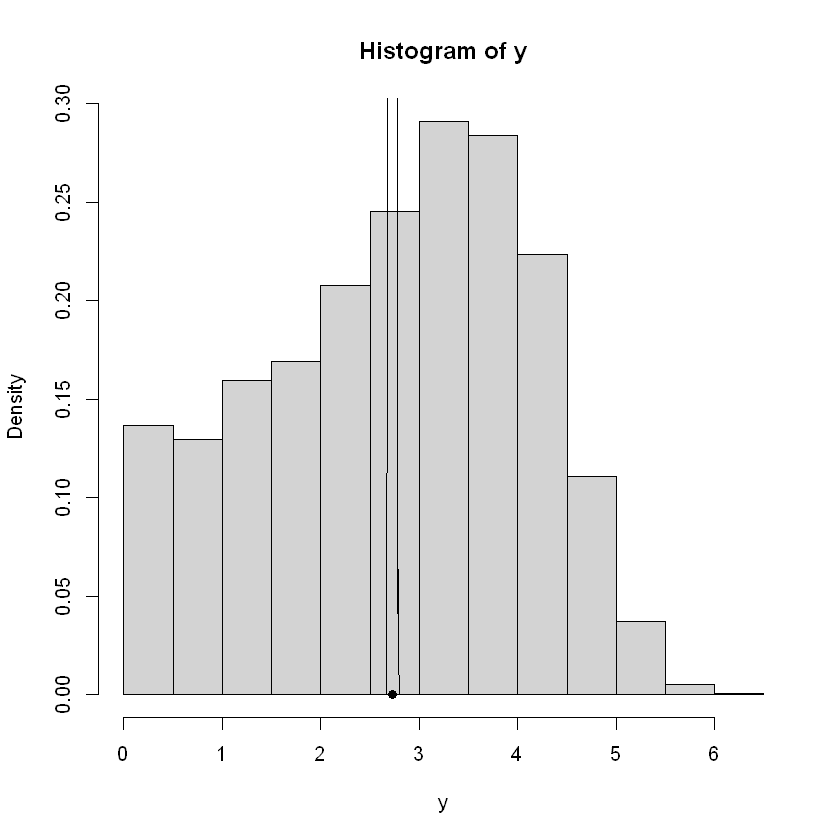

In [108]:
hist(y,probability = TRUE)
points(mean(y),0,pch = 19)
lines(density(post2$mu))
legend()